In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from architecture.MLP import FCNet
from utils import get_data, plotter
from collections import OrderedDict
from matplotlib import cm
from matplotlib.colors import Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
width = 4

#load data from data/moons.npz
file = np.load("data/moons.npz")
X_train = file["X_train"]
y_train = file["y_train"]
X_test = file["X_test"]
y_test = file["y_test"]

# define train and test loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
    ),
    batch_size=256,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
    ),
    batch_size=256,
    shuffle=False,
)

# choose two random indices from 0 to 49
idx1 = np.random.randint(0, 50)
idx2 = np.random.randint(0, 50)
while idx1 == idx2:
    idx2 = np.random.randint(0, 50)

# load both models
model1 = FCNet(2, width, 1, 1)
model2 = FCNet(2, width, 1, 1)

model1.load_state_dict(
    torch.load(f"models/moons/model_w{width}_{idx1}.pth")
)
model2.load_state_dict(
    torch.load(f"models/moons/model_w{width}_{idx2}.pth")
)

average_model = FCNet(2, width, 1, 1)
average_state_dict = OrderedDict()
for key in model1.state_dict():
    average_state_dict[key] = (model1.state_dict()[key] + model2.state_dict()[key]) / 2
average_model.load_state_dict(average_state_dict)

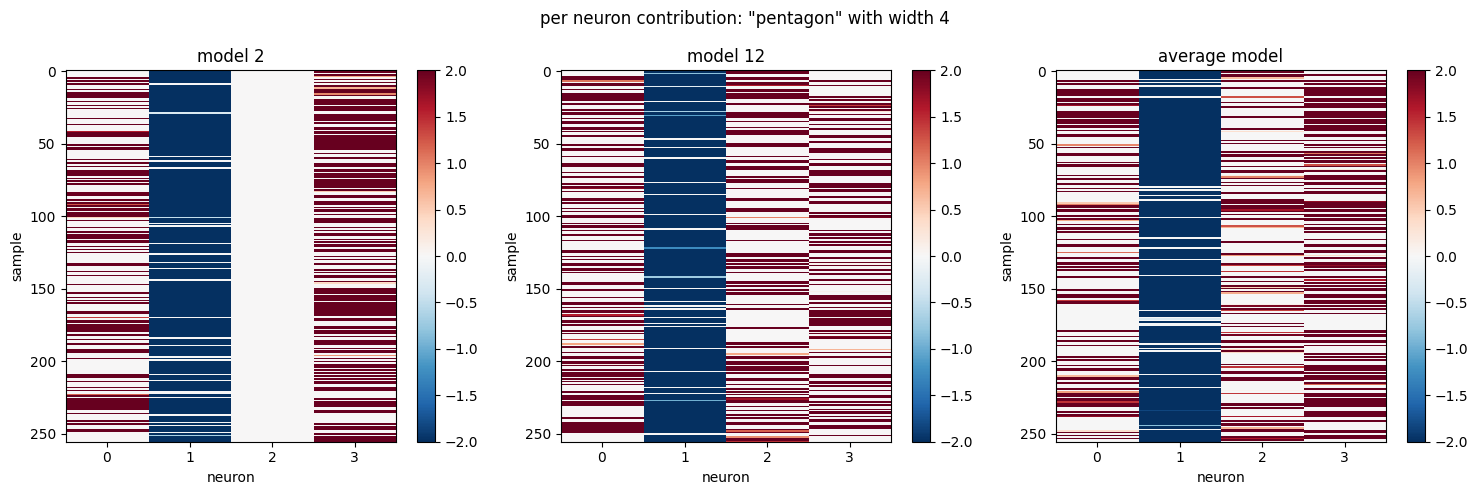

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title(f"model {idx1}")
axs[1].set_title(f"model {idx2}")
axs[2].set_title(f"average model")

for i, model in enumerate([model1, model2, average_model]):
    model.eval().to(device)
    out = []
    with torch.no_grad():
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1).float()
            a = torch.relu(model.layers[0](x))
            out.append(a.cpu().numpy())
    out = np.concatenate(out)
    # multiplyt with output weights
    out = out * model.layers[1].weight.detach().cpu().numpy()
    
    # plot as heatmap
    axs[i].imshow(out, aspect="auto", cmap="RdBu_r", interpolation="none", vmin=-2, vmax=2)
    # colorbar with min and max as -2 and 2
    cbar = axs[i].figure.colorbar(cm.ScalarMappable(cmap="RdBu_r", norm=Normalize(vmin=-2, vmax=2)), ax=axs[i])
    # labels
    axs[i].set_xlabel("neuron")
    axs[i].set_ylabel("sample")

# title
fig.suptitle(f"per neuron contribution: \"{dataset}\" with width {width}")
plt.tight_layout()
plt.show()

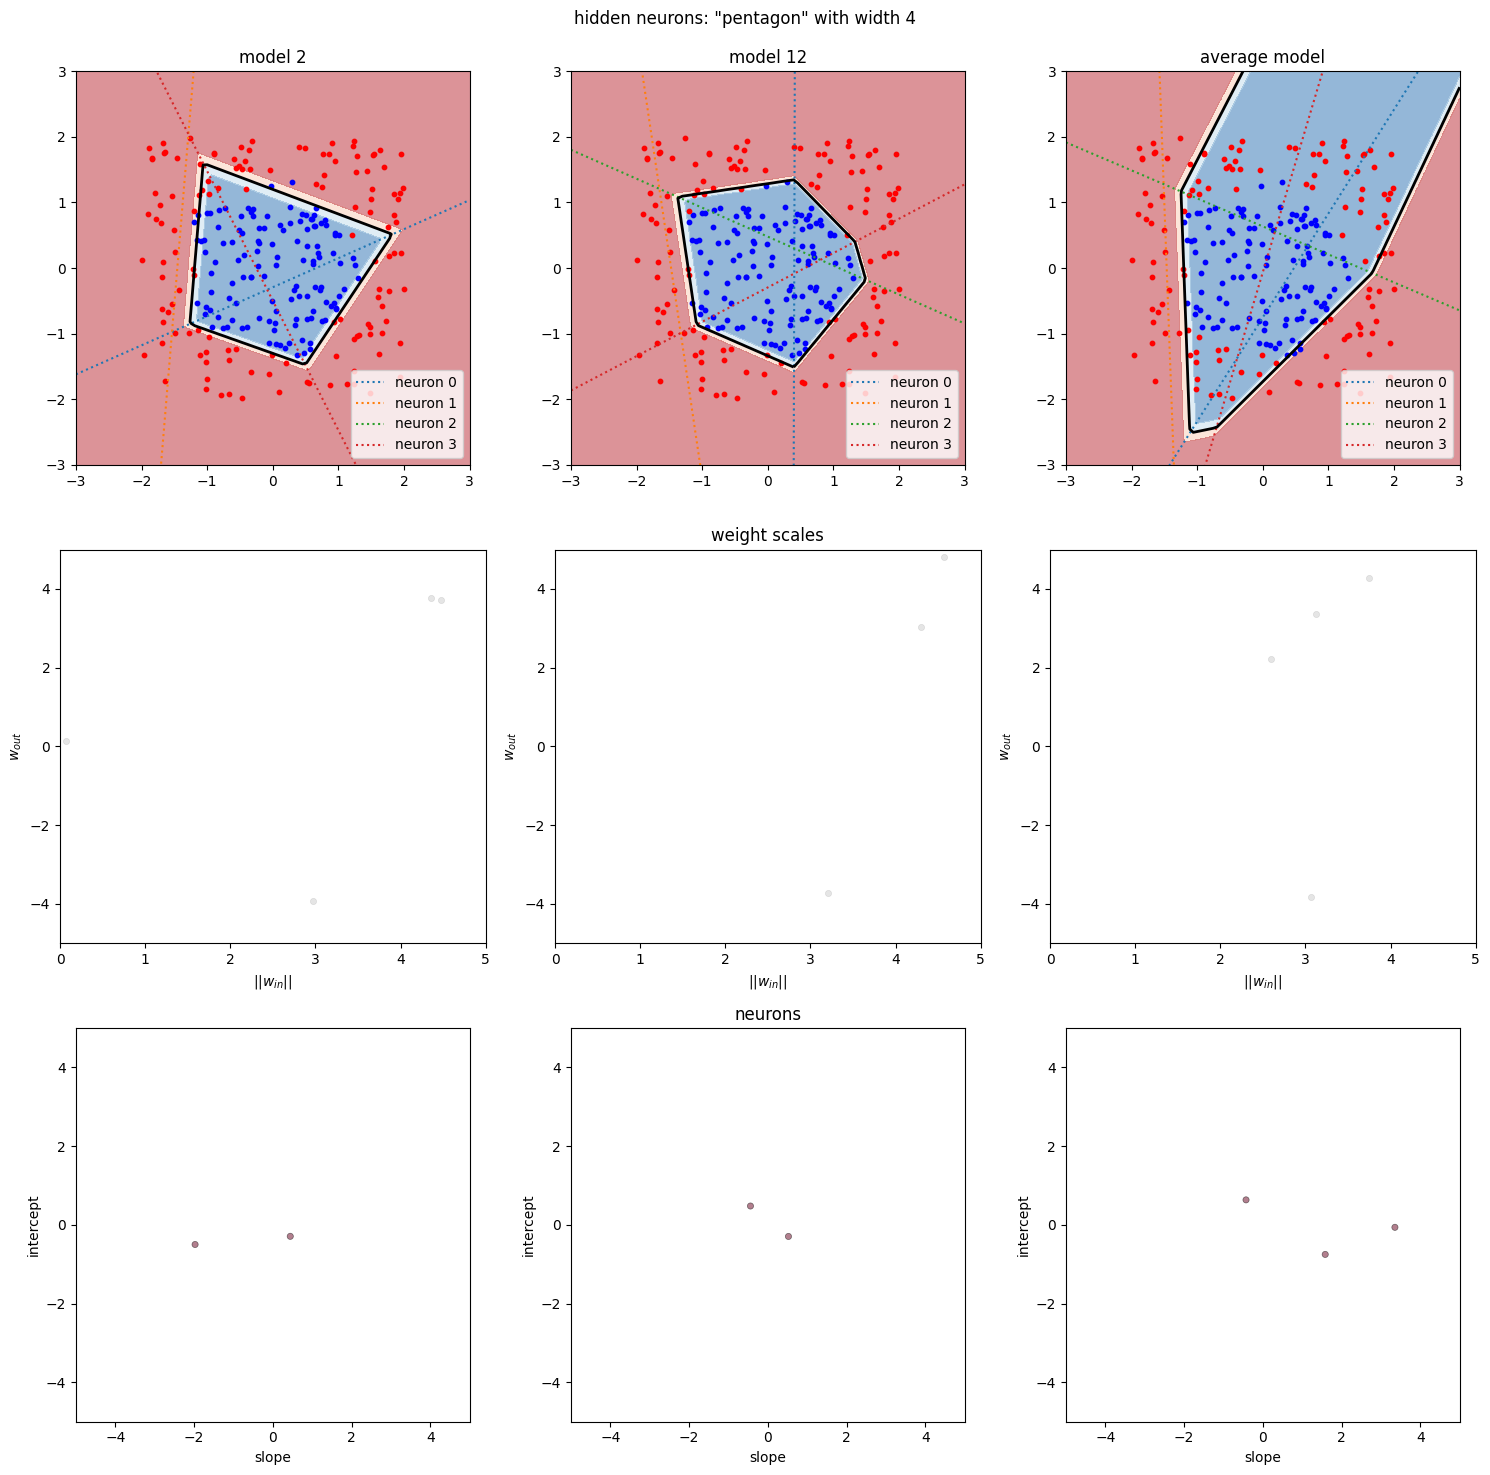

In [30]:
# plot all three for all three models
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

# set titles for each row
axs[0, 0].set_title(f"model {idx1}")
axs[0, 1].set_title(f"model {idx2}")
axs[0, 2].set_title(f"average model")

axs[1, 1].set_title(f"weight scales")
axs[2, 1].set_title(f"neurons")

for i, model in enumerate([model1, model2, average_model]):
    # decision boundary
    model.eval().to(device)
    x1 = np.linspace(-3, 3, 100)
    x2 = np.linspace(-3, 3, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
    X = torch.from_numpy(X).float().to(device)
    y = model(X).detach().cpu().numpy().reshape(100, 100)
    # apply sigmoid
    y = 1 / (1 + np.exp(-y))

    w_in = model.layers[0].weight.detach().cpu().numpy()
    w_in_norm = np.linalg.norm(w_in, axis=1)
    b_in = model.layers[0].bias.detach().cpu().numpy()
    w_out = model.layers[1].weight.detach().cpu().numpy()
    w_out = np.squeeze(w_out)
    # plot the lines corresponding to each hidden node
    for j in range(width):
        axs[0, i].plot(
            x1,
            -(w_in[j, 0] * x1 + b_in[j]) / w_in[j, 1],
            linestyle="dotted",
            alpha=1.0,
            c=f"C{j}",
            label=f"neuron {j}",
        )
    axs[0, i].contourf(x1, x2, y, 3, cmap="RdBu_r", alpha=0.5)
    # highlight line at 0.5
    axs[0, i].contour(x1, x2, y, levels=[0.5], colors="k", linewidths=2)
    axs[0, i].set_aspect("equal")
    axs[0, i].set_xlim(-3, 3)
    axs[0, i].set_ylim(-3, 3)

    # plot the training data
    for x_, y_ in train_loader:
        x_ = x_.numpy()
        y_ = y_.numpy()
        axs[0, i].scatter(x_[y_ == 0, 0], x_[y_ == 0, 1], c="b", s=10)
        axs[0, i].scatter(x_[y_ == 1, 0], x_[y_ == 1, 1], c="r", s=10)
    
    axs[0, i].legend()

    # in second row, plot w_in norm vs w_out
    axs[1, i].scatter(
        w_in_norm, w_out, c="k", alpha=0.1, s=20, edgecolors="k", linewidths=0.5
    )
    axs[1, i].set_xlabel("$\|| w_{in} \||$")
    axs[1, i].set_ylabel("$w_{out}$")
    axs[1, i].set_xlim(0, 5)
    axs[1, i].set_ylim(-5, 5)

    slope = -w_in[:, 0] / w_in[:, 1]
    intercept = -b_in / w_in[:, 1]
    # in third row, plot neurons as (slope, y_intercept) and color as (w_in norm * w_out)
    axs[2, i].scatter(
        slope,
        intercept,
        c=w_in_norm * w_out,
        cmap="RdBu_r",
        s=20,
        vmin=-2,
        vmax=2,
        alpha=0.5,
        edgecolors="k",
        linewidths=0.5,
    )
    axs[2, i].set_aspect("equal")
    axs[2, i].set_xlim(-5, 5)
    axs[2, i].set_ylim(-5, 5)
    axs[2, i].set_xlabel("slope")
    axs[2, i].set_ylabel("intercept")
fig.suptitle(f"hidden neurons: \"{dataset}\" with width {width}\n")
plt.tight_layout()
plt.show()

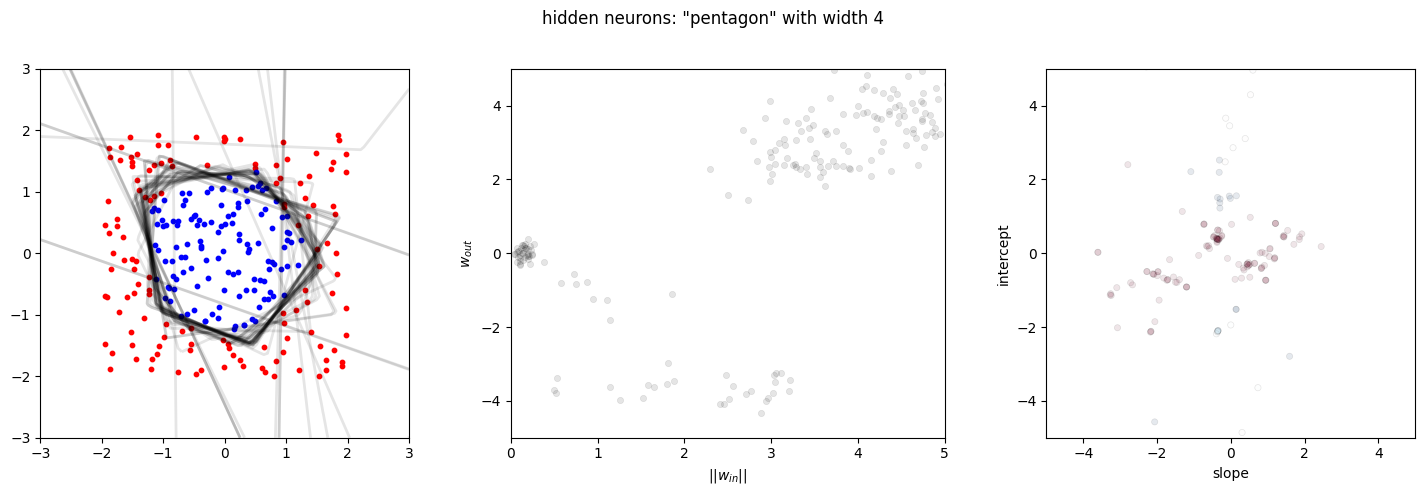

In [18]:
# for given dataset and width, plot all models
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

    
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
X = torch.from_numpy(X).float().to(device)

axs[0].set_aspect("equal")
axs[0].set_xlim(-3, 3)
axs[0].set_ylim(-3, 3)

axs[1].set_xlabel("$\|| w_{in} \||$")
axs[1].set_ylabel("$w_{out}$")
axs[1].set_xlim(0, 5)
axs[1].set_ylim(-5, 5)

axs[2].set_aspect("equal")
axs[2].set_xlim(-5, 5)
axs[2].set_ylim(-5, 5)
axs[2].set_xlabel("slope")
axs[2].set_ylabel("intercept")

# plot the training data
for x_, y_ in train_loader:
    x_ = x_.numpy()
    y_ = y_.numpy()
    axs[0].scatter(x_[y_ == 0, 0], x_[y_ == 0, 1], c="b", s=10)
    axs[0].scatter(x_[y_ == 1, 0], x_[y_ == 1, 1], c="r", s=10)

for i in range(50):
    model = FCNet(2, width, 1, 1)
    model.load_state_dict(torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{i}.pth"))
    model.eval().to(device)
    # decision boundary
    y = model(X).detach().cpu().numpy().reshape(100, 100)
    # apply sigmoid
    y = 1 / (1 + np.exp(-y))

    w_in = model.layers[0].weight.detach().cpu().numpy()
    w_in_norm = np.linalg.norm(w_in, axis=1)
    b_in = model.layers[0].bias.detach().cpu().numpy()
    w_out = model.layers[1].weight.detach().cpu().numpy()
    w_out = np.squeeze(w_out)

    # highlight line at 0.5
    axs[0].contour(x1, x2, y, levels=[0.5], colors="k", linewidths=2, alpha=0.1)

    # in second column, plot w_in norm vs w_out
    axs[1].scatter(
        w_in_norm, w_out, c="k", alpha=0.1, s=20, edgecolors="k", linewidths=0.5
    )

    slope = -w_in[:, 0] / w_in[:, 1]
    intercept = -b_in / w_in[:, 1]
    # in third column, plot neurons as (slope, y_intercept) and color as (w_in norm * w_out)
    axs[2].scatter(
        slope,
        intercept,
        c=w_in_norm * w_out,
        cmap="RdBu_r",
        s=20,
        vmin=-2,
        vmax=2,
        alpha=0.1,
        edgecolors="k",
        linewidths=0.5,
    )

fig.suptitle(f"hidden neurons: \"{dataset}\" with width {width}\n")
plt.tight_layout()
plt.show()